In [ ]:
# Этап 1. Генерация данных
# Изучите набор данных, располагающийся в архиве blood_cells.
# Выполните "нарезку" изображений. Сохраните в отдельные папки изображения фона и изображения клеток.
# Реализуйте генератор данных снимков клеток крови. На выходе генератор предосталвяет два изображения: сгенерированное без шума, сгенерированное с шумом.
# Патчи для формирования фона:
# 1) патчи, вырезанные из исходного набора данных
# 2) искусственно сформированные патчи (равномерная заливка фона из диапазона допустимых значений)
# Фон изображения формируется из набора патчей.
# Патчи для клеток крови:
# 1) патчи, вырезанные из исходного набора данных
# 2) искусствено сгенерированные окружности с заливкой из допустимого набора данных
# для blending-задачи применять: https://learnopencv.com/seamless-cloning-using-opencv-python-cpp/
# Примеры генераторов и загрузчиков данных найдете в исходной папке.
##########
# Основные этапы генерации:
# 1. Выбор, формирование патчей, их препроцессинг. Формирование(комбинирование) фона из набора патчей. Постпроцессинг результирующего фона.
# 2. Выбор метоположения клекток, выбор/формирование клеток, совмещение клеток на фоновом изображении
# 3. Выбор типа шума. Зашумление изображения.
#
# Генератор возвращает два изображения: зашумленное (этап 3) и исходное (этап 2) изображения.
#
# Этап 2. Исследование качества работы алгоритмов шумоподавления на сформированном датасете.
# Виды шумов:
# 1) Шум Гаусса
# 2) постоянный шум
# Виды фильтров:
# 1) Медианный фильтр
# 2) фильтр гаусса
# 3) билатериальный фильтр
# 4) фильтр нелокальных средних с различными параметрами.
# 5.1) самостоятелная реализация алгоритма шумоподавления (CPU)
# 5.2) самостоятелная реализация алгоритма шумоподавления (GPU)
# Метрики:
# 1) MSE
# 2) SSIM
# 3) время работы
#

In [15]:
import os
import cv2
import numpy as np
from PIL import Image
from skimage.metrics import mean_squared_error, structural_similarity
import time

# загрузка
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

# нарезка на патчи
def slice_image(image, mask, patch_size):
    patches = []
    for i in range(0, image.shape[0], patch_size):
        for j in range(0, image.shape[1], patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            mask_patch = mask[i:i+patch_size, j:j+patch_size]
            if np.any(mask_patch):  # Если клетка
                patches.append((patch, 'cell'))
            else:  # Если в патче только фон
                patches.append((patch, 'background'))
    return patches

# шум Гаусса
def add_gaussian_noise(image, mean=0, sigma=25):
    row, col, ch = image.shape
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy = image + gauss
    return np.clip(noisy, 0, 255).astype(np.uint8)

# постоянный шум
def add_salt_pepper_noise(image, amount=0.05):
    noisy = np.copy(image)
    num_salt = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy[coords] = 255
    num_pepper = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy[coords] = 0
    return noisy

# путь к папкам
original_train = load_images_from_folder('original_train1')
mask_train = load_images_from_folder('mask_train1')
original_test = load_images_from_folder('original_test')
mask_test = load_images_from_folder('mask_test')

patch_size = 64
train_patches = []
for img, mask in zip(original_train, mask_train):
    train_patches.extend(slice_image(img, mask, patch_size))

test_patches = []
for img, mask in zip(original_test, mask_test):
    test_patches.extend(slice_image(img, mask, patch_size))

def save_patches(patches, base_folder):
    cell_folder = os.path.join(base_folder, 'cells')
    background_folder = os.path.join(base_folder, 'background')
    os.makedirs(cell_folder, exist_ok=True)
    os.makedirs(background_folder, exist_ok=True)
    for i, (patch, label) in enumerate(patches):
        if label == 'cell':
            cv2.imwrite(os.path.join(cell_folder, f'patch_{i}.png'), patch)
        else:
            cv2.imwrite(os.path.join(background_folder, f'patch_{i}.png'), patch)

save_patches(train_patches, 'train_patches')
save_patches(test_patches, 'test_patches')

def data_generator(patches, noise_type='gaussian'):
    for patch, label in patches:
        if label == 'cell':
            noisy_patch = add_gaussian_noise(patch) if noise_type == 'gaussian' else add_salt_pepper_noise(patch)
            yield patch, noisy_patch

from skimage.metrics import structural_similarity

def apply_filters_and_evaluate(clean, noisy):
    start_time = time.time()
    gaussian_filtered = cv2.GaussianBlur(noisy, (5, 5), 0)
    median_filtered = cv2.medianBlur(noisy, 5)
    bilateral_filtered = cv2.bilateralFilter(noisy, 9, 75, 75)
    nlm_filtered = cv2.fastNlMeansDenoisingColored(noisy, None, 10, 10, 7, 21)

    # Проверка размера изображений
    min_size = min(clean.shape[0], clean.shape[1])
    if min_size < 7:
        raise ValueError("Изображение слишком маленькое")

    # Вычисление SSIM
    win_size = min(7, min_size)  # проуерка win_size
    ssim_gaussian = structural_similarity(clean, gaussian_filtered, win_size=win_size, channel_axis=2)
    ssim_median = structural_similarity(clean, median_filtered, win_size=win_size, channel_axis=2)
    ssim_bilateral = structural_similarity(clean, bilateral_filtered, win_size=win_size, channel_axis=2)
    ssim_nlm = structural_similarity(clean, nlm_filtered, win_size=win_size, channel_axis=2)

    # Вычисление MSE
    mse_gaussian = mean_squared_error(clean, gaussian_filtered)
    mse_median = mean_squared_error(clean, median_filtered)
    mse_bilateral = mean_squared_error(clean, bilateral_filtered)
    mse_nlm = mean_squared_error(clean, nlm_filtered)

    end_time = time.time()
    elapsed_time = end_time - start_time

    return {
        'gaussian': {'mse': mse_gaussian, 'ssim': ssim_gaussian},
        'median': {'mse': mse_median, 'ssim': ssim_median},
        'bilateral': {'mse': mse_bilateral, 'ssim': ssim_bilateral},
        'nlm': {'mse': mse_nlm, 'ssim': ssim_nlm},
        'time': elapsed_time
    }


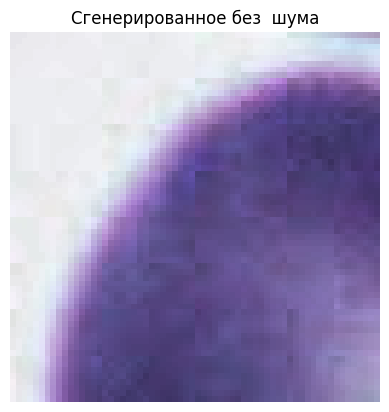

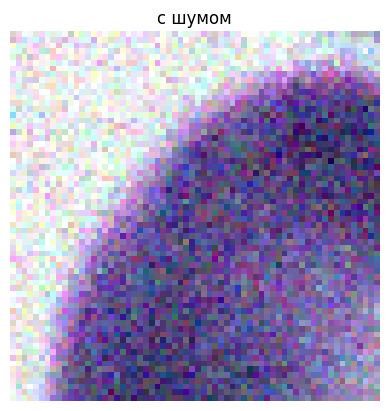

In [22]:
import matplotlib.pyplot as plt

def show_image(image, title):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

for clean, noisy in data_generator(train_patches):
    show_image(clean, 'Сгенерированное без  шума')
    show_image(noisy, 'с шумом')
    break

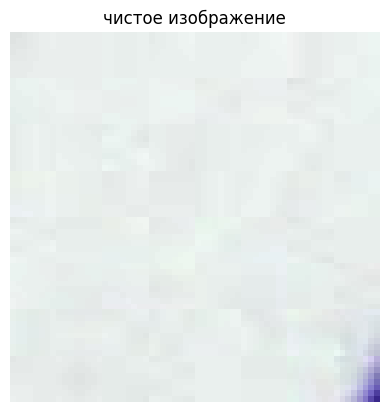

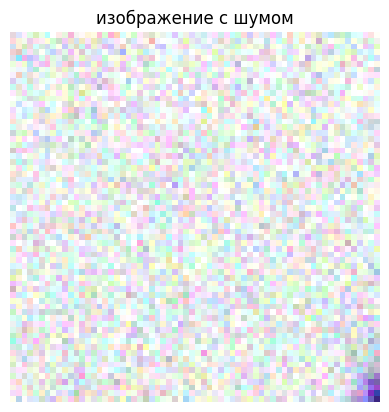

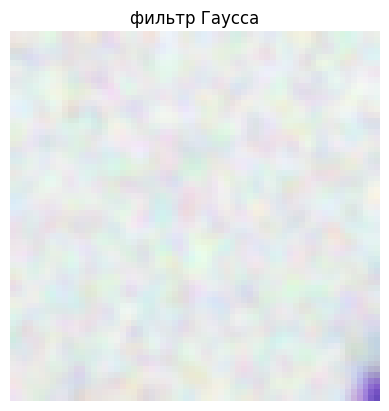

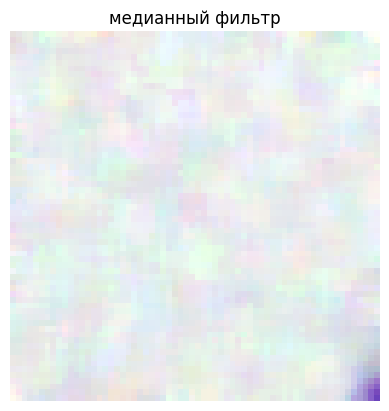

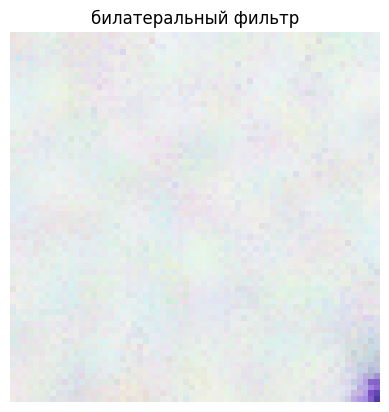

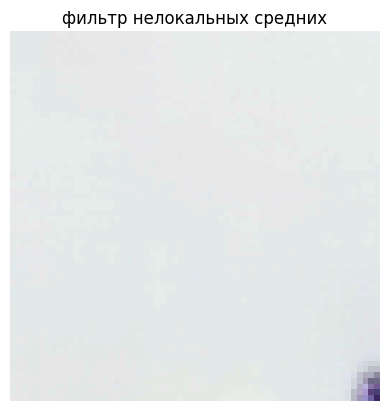

Gaussian:
  MSE: 50.24
  SSIM: 0.70
Median:
  MSE: 48.26
  SSIM: 0.68
Bilateral:
  MSE: 36.02
  SSIM: 0.76
Nlm:
  MSE: 31.21
  SSIM: 0.90
Время выполнения: 0.05 секунд


In [28]:
for clean, noisy in data_generator(test_patches):

    results = apply_filters_and_evaluate(clean, noisy)

    show_image(clean, 'чистое изображение')
    show_image(noisy, 'изображение с шумом')
    show_image(cv2.GaussianBlur(noisy, (5, 5), 0), 'фильтр Гаусса')
    show_image(cv2.medianBlur(noisy, 5), 'медианный фильтр')
    show_image(cv2.bilateralFilter(noisy, 9, 75, 75), 'билатеральный фильтр')
    show_image(cv2.fastNlMeansDenoisingColored(noisy, None, 10, 10, 7, 21), 'фильтр нелокальных средних')

    for filter_name, metrics in results.items():
        if filter_name == 'time':
            print(f"Время выполнения: {metrics:.2f} секунд")
        else:
            print(f"{filter_name.capitalize()}:")
            print(f"  MSE: {metrics['mse']:.2f}")
            print(f"  SSIM: {metrics['ssim']:.2f}")
    break

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/folder/mask_test.zip

Archive:  /content/drive/MyDrive/folder/mask_test.zip
   creating: mask_test/
  inflating: mask_test/e02301ac-68f7-4daf-b2ba-254b917f1cca.png  
  inflating: mask_test/e11515b4-9527-4c23-a0ba-43719bacca0d.png  
  inflating: mask_test/e13f2327-fbf4-4d84-a8c1-09cb1e449c8c.png  
  inflating: mask_test/e16c0dab-780d-4035-872e-1bb91e49f9d2.png  
  inflating: mask_test/e1937e32-85d5-4cd8-bb4a-b9cf8ee7ceeb.png  
  inflating: mask_test/e234ce8b-4ec4-4d93-9068-d7854d77ddf4.png  
  inflating: mask_test/e26b88c6-5884-4b5c-94d7-ad780379c8ad.png  
  inflating: mask_test/e36cb882-c6d0-4467-812e-d18c169a9a47.png  
  inflating: mask_test/e3ade58d-086c-47fa-9120-76beacb45395.png  
  inflating: mask_test/e3c1442a-717f-41dd-bf97-81e1233ac9fa.png  
  inflating: mask_test/e3e9c2de-0a24-4c7e-8a69-3d3093d5bdab.png  
  inflating: mask_test/e3ea07d7-884a-412e-874a-40fd6b856736.png  
  inflating: mask_test/e40000b4-1b26-42ce-909d-4715e04f0a6e.png  
  inflating: mask_test/e474a20b-2769-48f1-a520-4f6ef5a0dbf5.png 

In [14]:
!unzip /content/drive/MyDrive/folder/mask_train1.zip

Archive:  /content/drive/MyDrive/folder/mask_train1.zip
   creating: mask_train1/
  inflating: mask_train1/592c941a-aa54-4971-b499-dc47356f80a3.png  
  inflating: mask_train1/5939f341-a886-4f63-ae87-2219d000a1d4.png  
  inflating: mask_train1/597bbff8-6592-41cf-8946-e59b0d1f289a.png  
  inflating: mask_train1/59daa25e-85d6-42f2-8f39-cc9f9d5d252e.png  
  inflating: mask_train1/59dc7da9-35d1-421e-a61b-1e9637bfbfa1.png  
  inflating: mask_train1/59f5699f-885f-4004-b783-a60060144e43.png  
  inflating: mask_train1/5a539312-6cfa-43e6-8d5d-db883f343ad9.png  
  inflating: mask_train1/5a631871-2fc7-4a68-9c39-f3b9a0bf4a04.png  
  inflating: mask_train1/5bf91ff9-80df-49c0-9c3e-599357d95530.png  
  inflating: mask_train1/5bfde411-aa51-45d0-8b67-a57c5f1e628b.png  
  inflating: mask_train1/5c037ffc-f515-48b3-b231-c110fbd2b8ca.png  
  inflating: mask_train1/5c399ab9-492c-4bfc-a452-83aba574a3bc.png  
  inflating: mask_train1/5c5b7965-1a44-44b8-aa43-660823e61821.png  
  inflating: mask_train1/5c68070c-

In [ ]:
!unzip /content/drive/MyDrive/folder/original_test.zip

Archive:  /content/drive/MyDrive/folder/original_test.zip
   creating: original_test/
  inflating: original_test/e02301ac-68f7-4daf-b2ba-254b917f1cca.jpg  
  inflating: original_test/e11515b4-9527-4c23-a0ba-43719bacca0d.png  
  inflating: original_test/e13f2327-fbf4-4d84-a8c1-09cb1e449c8c.png  
  inflating: original_test/e16c0dab-780d-4035-872e-1bb91e49f9d2.png  
  inflating: original_test/e1937e32-85d5-4cd8-bb4a-b9cf8ee7ceeb.png  
  inflating: original_test/e234ce8b-4ec4-4d93-9068-d7854d77ddf4.png  
  inflating: original_test/e26b88c6-5884-4b5c-94d7-ad780379c8ad.jpg  
  inflating: original_test/e36cb882-c6d0-4467-812e-d18c169a9a47.png  
  inflating: original_test/e3ade58d-086c-47fa-9120-76beacb45395.png  
  inflating: original_test/e3c1442a-717f-41dd-bf97-81e1233ac9fa.png  
  inflating: original_test/e3e9c2de-0a24-4c7e-8a69-3d3093d5bdab.png  
  inflating: original_test/e3ea07d7-884a-412e-874a-40fd6b856736.png  
  inflating: original_test/e40000b4-1b26-42ce-909d-4715e04f0a6e.png  
  in

In [13]:
!unzip /content/drive/MyDrive/folder/original_train1.zip

Archive:  /content/drive/MyDrive/folder/original_train1.zip
   creating: original_train1/
  inflating: original_train1/002f20ad-2ace-499c-9335-c9080bc3e6b5.png  
  inflating: original_train1/00a02700-2ea2-4590-9e15-ffc9160fd3de.png  
  inflating: original_train1/00c8364b-8c85-4502-bcfe-64736fe76815.png  
  inflating: original_train1/00d04a90-80e5-4bce-9511-1b64eabb7a47.png  
  inflating: original_train1/01b38a56-13eb-447b-89ee-fc21cb40dcc1.png  
  inflating: original_train1/01b99da8-b66b-464b-a7ee-1cadab8db18b.png  
  inflating: original_train1/02ea7aa8-c142-4a3d-939f-e77689741341.png  
  inflating: original_train1/0a747cb3-c720-4572-a661-ab5670a5c42e.png  
  inflating: original_train1/0a7bfa8a-ee52-4f7a-b9c5-2919ecfa93ef.png  
  inflating: original_train1/0ab56f9a-846d-49e2-a617-c6cc477fdfad.png  
  inflating: original_train1/0ac747cd-ff32-49bf-bc1a-3e9b7702ce9c.png  
  inflating: original_train1/0b04ec46-5119-4cda-8c35-c4e5b6f0eed0.png  
  inflating: original_train1/0b923ab7-ebff-407

In [12]:
# Удаление папки "my_folder" и всего её содержимого
!rm -rf /content/train_patches